# TensorFlow Hub SSD

> ## Image & Video Object Detection

- Pretrained 모델 로드 후 Object Detection 수행

In [2]:
import warnings
warnings.filterwarnings('ignore')

# I. TensorFlow Version

- Import TensorFlow

In [3]:
import tensorflow as tf

- TensorFlow Version

In [4]:
tf.__version__

'2.12.0'

- GPU Information

In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# II. Image File Download

- KIA.jpg 다운로드

In [6]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/image/KIA.jpg

--2023-04-17 07:45:03--  https://raw.githubusercontent.com/rusita-ai/pyData/master/image/KIA.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65805 (64K) [image/jpeg]
Saving to: ‘KIA.jpg’

KIA.jpg             100%[===================>]  64.26K  --.-KB/s    in 0.01s   

2023-04-17 07:45:03 (4.28 MB/s) - ‘KIA.jpg’ saved [65805/65805]



- KIA.jpg 확인

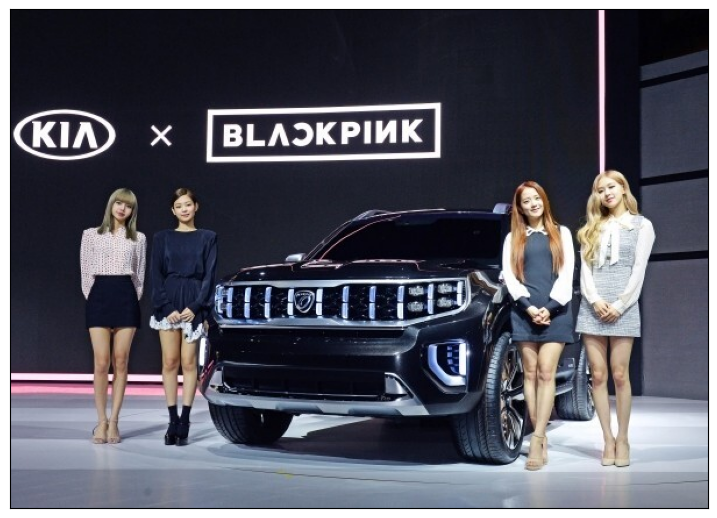

Image Shape : (429, 600, 3)


In [9]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/KIA.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (9, 9))
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.show()

print('Image Shape :', img.shape)

# III. TenSorFlow Hub

> ## 1) SSD Model Load

- detector_model

In [10]:
import tensorflow_hub as hub

module_ssd = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'

detector_model = hub.load(module_ssd)

> ## 2) Class ID Setting

- COCO Dataset
  - TensorFlow SSD

In [11]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                   11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                   21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                   31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                   41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                   51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                   61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                   71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                   81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                   91:'hair brush'}

# IV. Image Inference

> ## 1) Inference 수행 및 시각화

car : 0.8036
person : 0.6680
person : 0.6167
person : 0.5495
person : 0.5462


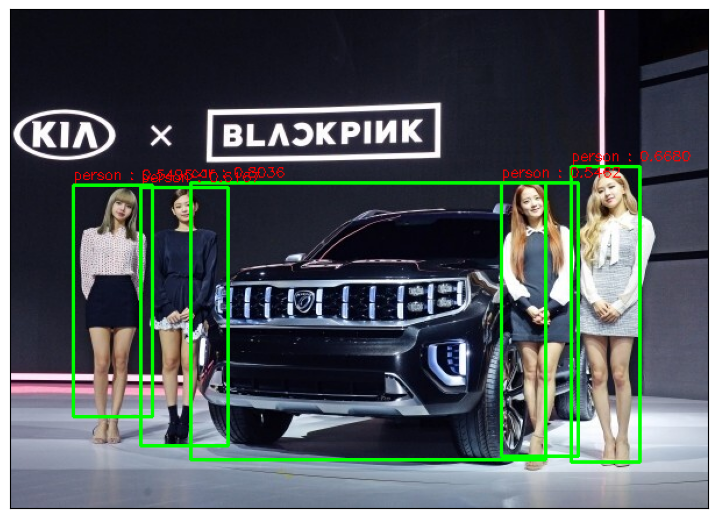

In [15]:
img_array = cv2.cvtColor(cv2.imread('/content/KIA.jpg'), cv2.COLOR_BGR2RGB)

# 원복을 위한 원본 이미지 shape 정보 저장
height = img_array.shape[0]
width = img_array.shape[1]
# 결과 출력 생성용 백업 이미지
draw_img = img_array.copy()

# Bounding Box 및 Caption 글자색
green_color = (0, 255, 0)
red_color = (255, 0, 0)

# Rank 4 Tensor 변환
img_tensor = tf.convert_to_tensor(img_array, dtype = tf.uint8)[tf.newaxis, ...]

# SSD object Detection 수행
result = detector_model(img_tensor)
# Dictionary to Array
result = {key:value.numpy() for key,value in result.items()}

# Threshold and Detection Count
SCORE_THRESHOLD = 0.5
OBJECT_DEFAULT_COUNT = 100
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
    score = result['detection_scores'][0, i]
    if score < SCORE_THRESHOLD:
        break
    box = result['detection_boxes'][0, i]

# Bounding Box 정보 : ymin, xmin, ymax, xmax 순서 주의
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    class_id = result['detection_classes'][0, i]
    caption = "{} : {:.4f}".format(labels_to_names[class_id], score)
    print(caption)

    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color = green_color, thickness = 2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize = (9, 9))
plt.imshow(draw_img)
plt.xticks([])
plt.yticks([])
plt.show()

> ## 2) get_detected_img( ) 정의

In [18]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count = 100, is_print = True):
    height = img_array.shape[0]
    widht = img_array.shape[1]

    draw_img = img_array.copy()

    green_color = (0, 255, 0)
    red_color = (255, 0, 0)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

    start_time = time.time()
    result = model(img_tensor)
    result = {key:value.numpy() for key,value in result.items()}

    for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
        score = result['detection_scores'][0, i]
        if score < score_threshold:
            break
        box = result['detection_boxes'][0, i]

        left = box[1] * width
        top = box[0] * height
        right = box[3] * width
        bottom = box[2] * height

        class_id = result['detection_classes'][0, i]
        caption = "{} : {:.4f}".format(labels_to_names[class_id], score)
        print(caption)

        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color = green_color, thickness = 2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
        if is_print:
            print('Detection Time :', round(time.time() - start_time, 2), 'Seconds')

    return draw_img

> ## 3) get_detected_img( ) 실행

car : 0.8036
Detection Time : 0.11 Seconds
person : 0.6680
Detection Time : 0.11 Seconds
person : 0.6167
Detection Time : 0.11 Seconds
person : 0.5495
Detection Time : 0.11 Seconds
person : 0.5462
Detection Time : 0.11 Seconds


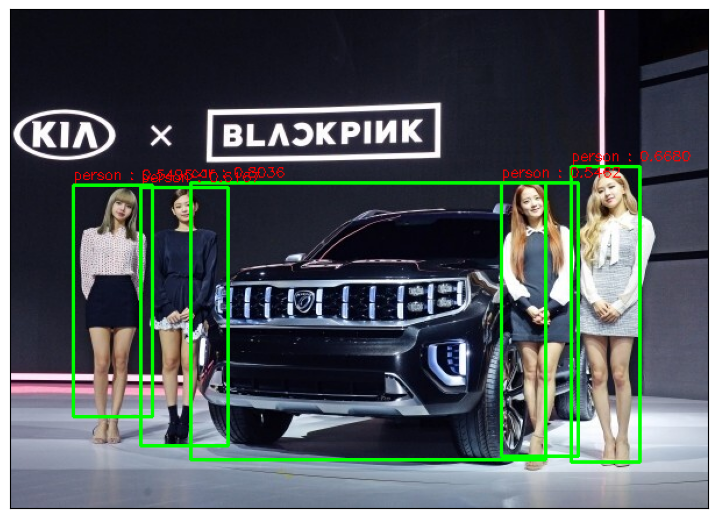

In [19]:
img_array = cv2.cvtColor(cv2.imread('/content/KIA.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold = 0.5, object_show_count = 100, is_print = True)

plt.figure(figsize = (9, 9))
plt.imshow(draw_img)
plt.xticks([])
plt.yticks([])
plt.show()

# V. Video Inference

> ## 1) matrix.mp4 Download

In [20]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/image/matrix.mp4

--2023-04-17 08:12:55--  https://raw.githubusercontent.com/rusita-ai/pyData/master/image/matrix.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386522 (377K) [application/octet-stream]
Saving to: ‘matrix.mp4’

matrix.mp4          100%[===================>] 377.46K  --.-KB/s    in 0.04s   

2023-04-17 08:12:56 (8.78 MB/s) - ‘matrix.mp4’ saved [386522/386522]



> ## 2) do_detected_video( ) 정의

In [21]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('Frame Count:', frame_cnt)

    green_color = (0, 255, 0)
    red_color = (255, 0, 0)

    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('No more Frames')
            break
        img_frame = get_detected_img(model, img_frame, score_threshold = score_threshold, object_show_count = 100, is_print = is_print)

        vid_writer.write(img_frame)
        
    vid_writer.release()
    cap.release()

> ## 3) do_detected_video( ) 실행

In [ ]:

%%time
do_detected_video(detector_model, '/content/matrix.mp4', '/content/matrix_thssd.mp4', 0.4, True)

Frame Count: 134
airplane : 0.6771
Detection Time : 0.21 Seconds
airplane : 0.6314
Detection Time : 0.21 Seconds
airplane : 0.6049
Detection Time : 0.19 Seconds
car : 0.4959
Detection Time : 0.19 Seconds
airplane : 0.4398
Detection Time : 0.19 Seconds
airplane : 0.6474
Detection Time : 0.17 Seconds
airplane : 0.6461
Detection Time : 0.17 Seconds
airplane : 0.6516
Detection Time : 0.11 Seconds
car : 0.6037
Detection Time : 0.11 Seconds
airplane : 0.5687
Detection Time : 0.11 Seconds
car : 0.5305
Detection Time : 0.11 Seconds
car : 0.5138
Detection Time : 0.11 Seconds
car : 0.5132
Detection Time : 0.11 Seconds
airplane : 0.4904
Detection Time : 0.11 Seconds
car : 0.4519
Detection Time : 0.11 Seconds
car : 0.4252
Detection Time : 0.11 Seconds
airplane : 0.6489
Detection Time : 0.11 Seconds
car : 0.6016
Detection Time : 0.11 Seconds
airplane : 0.5685
Detection Time : 0.11 Seconds
car : 0.5270
Detection Time : 0.11 Seconds
car : 0.5162
Detection Time : 0.11 Seconds
car : 0.5120
Detection Ti